librares

In [1]:
import numpy as np
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16,EfficientNetB7, ResNet50, DenseNet121, EfficientNetB0,InceptionV3 ,MobileNetV2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns


In [2]:
import tensorflow as tf
import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)


TensorFlow Version: 2.17.1
Keras Version: 3.5.0


load data

In [3]:
# Paths
dataset_1 = "/kaggle/input/pcos-detection-using-ultrasound-images/data/train"
dataset_2= "/kaggle/input/pcos-images/Dataset pcos"


In [4]:
for class_name in os.listdir(dataset_1):
    print(f"{class_name}: {len(os.listdir(os.path.join(dataset_1, class_name)))} train images")
    
for class_name in os.listdir(dataset_2):
    print(f"{class_name}: {len(os.listdir(os.path.join(dataset_2, class_name)))} test images")


infected: 781 train images
notinfected: 1143 train images
Normal: 100 test images
PCOS: 100 test images


In [5]:
# New combined dataset path
combined_dir = "/kaggle/working/dataset"
new_train_dir = "/kaggle/working/train"
new_test_dir = "/kaggle/working/test"

# Create directories
os.makedirs(combined_dir, exist_ok=True)
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

# Define the correct class mappings
class_mapping = {
    "notinfected": "Normal",
    "infected": "PCOS",
    "Normal": "Normal",
    "PCOS": "PCOS"
}

In [6]:
# Merge both datasets under the correct class names
for dataset_path in [dataset_1, dataset_2]:
    for class_name in os.listdir(dataset_path):
        original_class_path = os.path.join(dataset_path, class_name)

        # Skip if not a directory
        if not os.path.isdir(original_class_path):
            continue

        # Get the correct class name (mapping infected → PCOS, notinfected → Normal)
        new_class_name = class_mapping.get(class_name, None)
        if new_class_name is None:
            print(f" Warning: Unknown class '{class_name}', skipping.")
            continue

        # Create new class directory in combined dataset
        combined_class_path = os.path.join(combined_dir, new_class_name)
        os.makedirs(combined_class_path, exist_ok=True)

        # Copy images
        for img in os.listdir(original_class_path):
            shutil.copy(os.path.join(original_class_path, img), os.path.join(combined_class_path, img))


In [7]:
# split into train (90%) and test (10%)
for class_name in ["Normal", "PCOS"]:
    class_path = os.path.join(combined_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    # Create train/test class folders
    os.makedirs(os.path.join(new_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(new_test_dir, class_name), exist_ok=True)

    # Split 90% train, 10% test
    split_index = int(0.9 * len(images))
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Copy images to new train and test directories
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_train_dir, class_name, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_test_dir, class_name, img))

In [8]:
print(f" Train folder: {new_train_dir}")
print(f" Test folder: {new_test_dir}")

 Train folder: /kaggle/working/train
 Test folder: /kaggle/working/test


In [9]:
for class_name in os.listdir(new_train_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(new_train_dir, class_name)))} train images")
    
for class_name in os.listdir(new_test_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(new_test_dir, class_name)))} test images")


PCOS: 792 train images
Normal: 1118 train images
PCOS: 89 test images
Normal: 125 test images


In [10]:
# Parameters
batch_size = 128
img_height = img_width = 224

In [11]:
# Define data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    new_train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='binary', subset="training"
,color_mode="rgb",seed=12)



test_generator= test_datagen.flow_from_directory(
    new_test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    color_mode="rgb",
    shuffle=False 
)

Found 1910 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [13]:
# Set input shape
IMG_SIZE = (224, 224,3)  
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE) 

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x) 

# Define the final model
model_vgg = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_vgg.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# Train model
history_vgg= model_vgg.fit(
    train_generator,
    epochs=5,
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.6073 - loss: 0.6660
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 837ms/step - accuracy: 0.8881 - loss: 0.3811
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 841ms/step - accuracy: 0.9544 - loss: 0.2256
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 844ms/step - accuracy: 0.9723 - loss: 0.1414
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 830ms/step - accuracy: 0.9855 - loss: 0.0943


In [14]:
model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 15,109,445 (57.64 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 263,172 (1.00 MB)

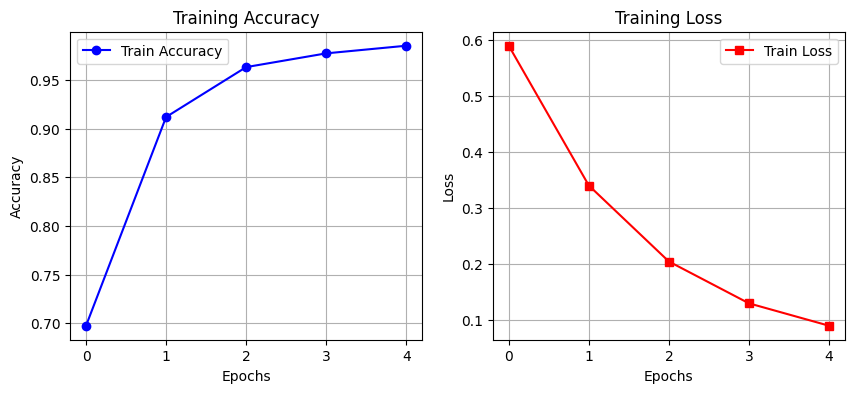

In [15]:

# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# Training Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.grid(True)

# Training Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history["loss"], label="Train Loss", marker='s', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.show()


In [16]:
# Evaluate model on teat 
test_loss, test_acc =model_vgg.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Make Predictions
y_true = test_generator.classes
y_pred_probs = model_vgg.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 16s/step - accuracy: 1.0000 - loss: 0.0334
Test Loss: 0.0357, Test Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 520ms/step


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        89

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



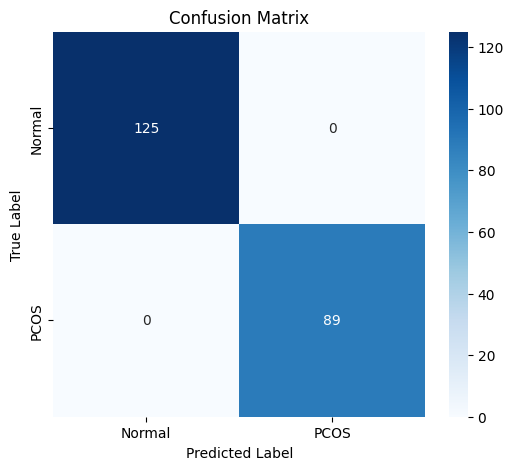

In [17]:
# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x)

# Create model
model_mobilenet = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model_mobilenet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
history_mobile = model_mobilenet.fit(
    train_generator,
    epochs=5,
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 887ms/step - accuracy: 0.6765 - loss: 10.5815
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 757ms/step - accuracy: 0.9653 - loss: 0.5796
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 763ms/step - accuracy: 0.9898 - loss: 0.1056
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 770ms/step - accuracy: 0.9953 - loss: 0.0375
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 766ms/step - accuracy: 0.9968 - loss: 0.0287


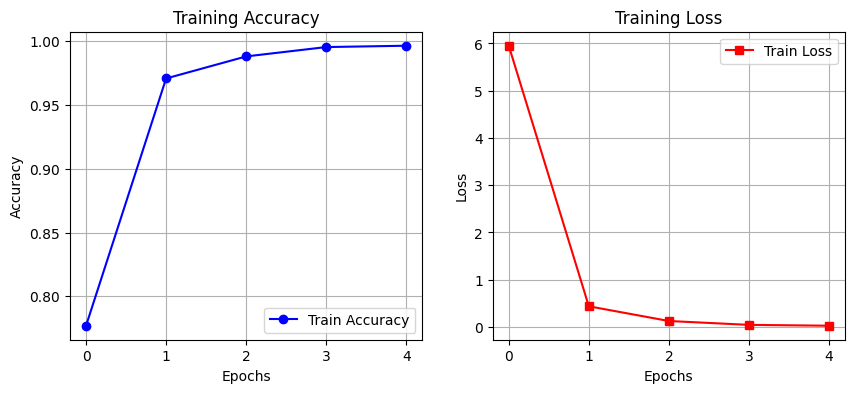

In [19]:

# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# Training Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_mobile.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.grid(True)

# Training Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_mobile.history["loss"], label="Train Loss", marker='s', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 1.0000 - loss: 2.0195e-12
Test Loss: 0.0000, Test Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        89

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



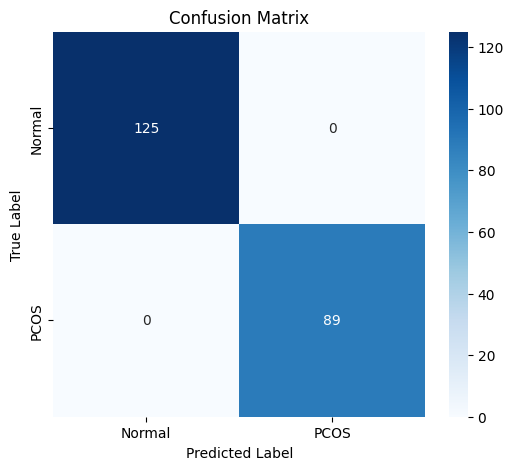

In [20]:
# Evaluate model on teat 
test_loss, test_acc =model_mobilenet.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Make Predictions
y_true = test_generator.classes
y_pred_probs =model_mobilenet.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [21]:
  
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))  
# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Fully Connected Layers for Binary Classification
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x) 

# Define the final model
model_resnet= Model(inputs=base_model.input, outputs=output_layer)
# Compile the model
model_resnet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
history_resnet50 = model_resnet.fit(
    train_generator,
    epochs=5,
    verbose=1
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5265 - loss: 6.8957
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 815ms/step - accuracy: 0.5529 - loss: 2.2007
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 814ms/step - accuracy: 0.7897 - loss: 0.4684
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 810ms/step - accuracy: 0.8386 - loss: 0.3765
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 813ms/step - accuracy: 0.9014 - loss: 0.2872


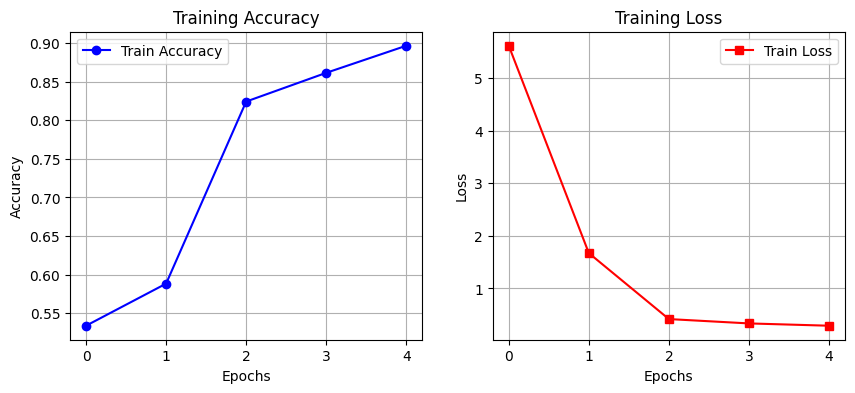

In [22]:

# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# Training Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.grid(True)

# Training Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history["loss"], label="Train Loss", marker='s', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.9938 - loss: 0.1004
Test Loss: 0.0951, Test Accuracy: 0.9907
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       125
           1       1.00      0.98      0.99        89

    accuracy                           0.99       214
   macro avg       0.99      0.99      0.99       214
weighted avg       0.99      0.99      0.99       214



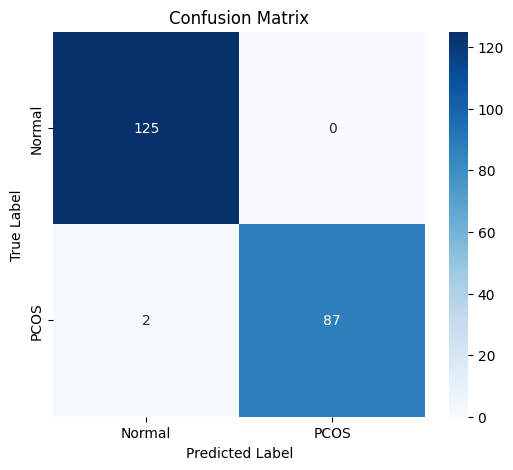

In [23]:
# Evaluate model on teat 1
test_loss, test_acc =model_resnet.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Make Predictions
y_true = test_generator.classes
y_pred_probs =model_resnet.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:

 
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))  
# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Fully Connected Layers for Binary Classification
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x) 
# Define the final model
model_inception = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model_inception.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# Train model
history_inception = model_inception.fit(
    train_generator,
    epochs=5,
    verbose=1
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5541 - loss: 16.3550
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 790ms/step - accuracy: 0.8443 - loss: 1.8360
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 803ms/step - accuracy: 0.9566 - loss: 0.2805
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 781ms/step - accuracy: 0.9835 - loss: 0.0708
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 784ms/step - accuracy: 0.9892 - loss: 0.0455


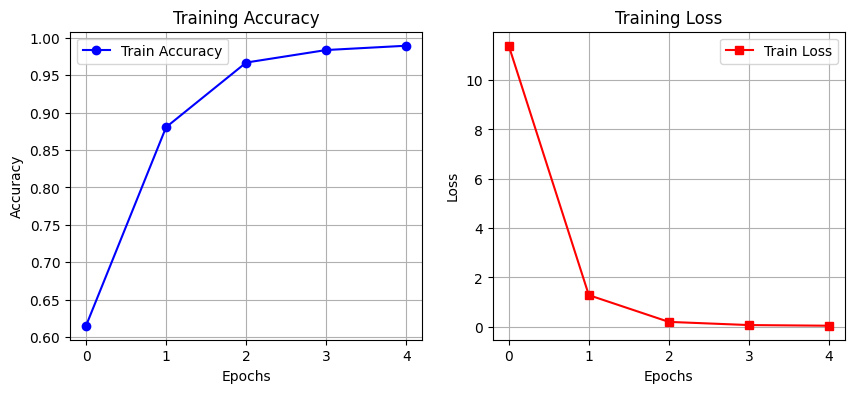

In [25]:

# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# Training Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_inception.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.grid(True)

# Training Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_inception.history["loss"], label="Train Loss", marker='s', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 1.0000 - loss: 4.6635e-04
Test Loss: 0.0006, Test Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        89

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



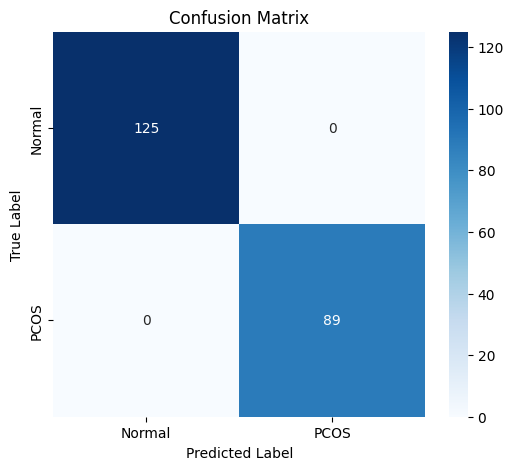

In [26]:
# Evaluate model on teat 1
test_loss, test_acc =model_inception.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Make Predictions
y_true = test_generator.classes
y_pred_probs =model_inception.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [27]:
  
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))  
# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Fully Connected Layers for Binary Classification
x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x) 

# Define the final model
model_DenseNet121= Model(inputs=base_model.input, outputs=output_layer)
# Compile the model
model_DenseNet121.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
history_DenseNet121 = model_DenseNet121.fit(
    train_generator,
    epochs=5,
    verbose=1
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5635 - loss: 13.1828
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 801ms/step - accuracy: 0.8415 - loss: 1.4830
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 801ms/step - accuracy: 0.9696 - loss: 0.2556
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 796ms/step - accuracy: 0.9852 - loss: 0.0631
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 799ms/step - accuracy: 0.9891 - loss: 0.0660


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 11s/step - accuracy: 1.0000 - loss: 6.1565e-08
Test Loss: 0.0000, Test Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        89

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



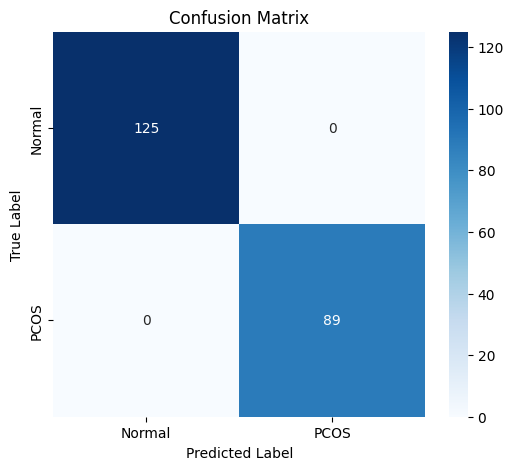

In [28]:
# Evaluate model on teat 1
test_loss, test_acc =model_DenseNet121.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Make Predictions
y_true = test_generator.classes
y_pred_probs =model_DenseNet121.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

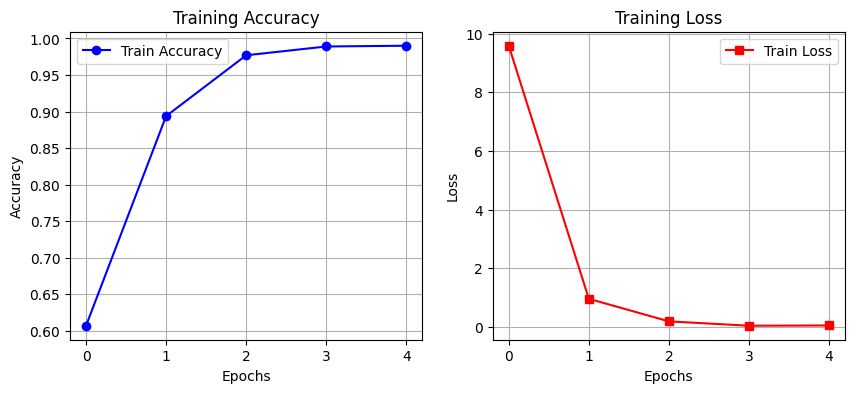

In [29]:

# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# Training Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_DenseNet121.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.grid(True)

# Training Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_DenseNet121.history["loss"], label="Train Loss", marker='s', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.show()


In [30]:
test_results = {
    "VGG16": model_vgg.evaluate(test_generator, verbose=1),
    "MobileNetV2": model_mobilenet.evaluate(test_generator, verbose=1),
    "ResNet50": model_resnet.evaluate(test_generator, verbose=1),
    "InceptionV3": model_inception.evaluate(test_generator, verbose=1),
    "DenseNet121":model_DenseNet121.evaluate(test_generator, verbose=1),
}

print("\nTest Accuracy and Loss for Each Model:")
for model, result in test_results.items():
    print(f"{model}: Loss = {result[0]:.4f}, Accuracy = {result[1]:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 1.0000 - loss: 0.0334
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 2.0195e-12
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9938 - loss: 0.1004
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 4.6635e-04
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 6.1565e-08

Test Accuracy and Loss for Each Model:
VGG16: Loss = 0.0357, Accuracy = 1.0000
MobileNetV2: Loss = 0.0000, Accuracy = 1.0000
ResNet50: Loss = 0.0951, Accuracy = 0.9907
InceptionV3: Loss = 0.0006, Accuracy = 1.0000
DenseNet121: Loss = 0.0000, Accuracy = 1.0000


In [31]:
# Extract final training accuracy from the history object
train_accuracies = {
    "VGG16": history_vgg.history['accuracy'][-1],
    "MobileNetV2": history_mobile.history['accuracy'][-1],
    "ResNet50": history_resnet50.history['accuracy'][-1],
    "InceptionV3": history_inception.history['accuracy'][-1],
    "DenseNet121": history_DenseNet121.history['accuracy'][-1],
}



# Print test results
print("\nTest Accuracy and Loss for Each Model:")
for model, result in test_results.items():
    print(f"{model}: Loss = {result[0]:.4f}, Accuracy = {result[1]:.4f}")

# Print train accuracy
print("\nTrain Accuracy for Each Model:")
for model, acc in train_accuracies.items():
    print(f"{model}: Accuracy = {acc:.4f}")



Test Accuracy and Loss for Each Model:
VGG16: Loss = 0.0357, Accuracy = 1.0000
MobileNetV2: Loss = 0.0000, Accuracy = 1.0000
ResNet50: Loss = 0.0951, Accuracy = 0.9907
InceptionV3: Loss = 0.0006, Accuracy = 1.0000
DenseNet121: Loss = 0.0000, Accuracy = 1.0000

Train Accuracy for Each Model:
VGG16: Accuracy = 0.9853
MobileNetV2: Accuracy = 0.9963
ResNet50: Accuracy = 0.8963
InceptionV3: Accuracy = 0.9895
DenseNet121: Accuracy = 0.9901


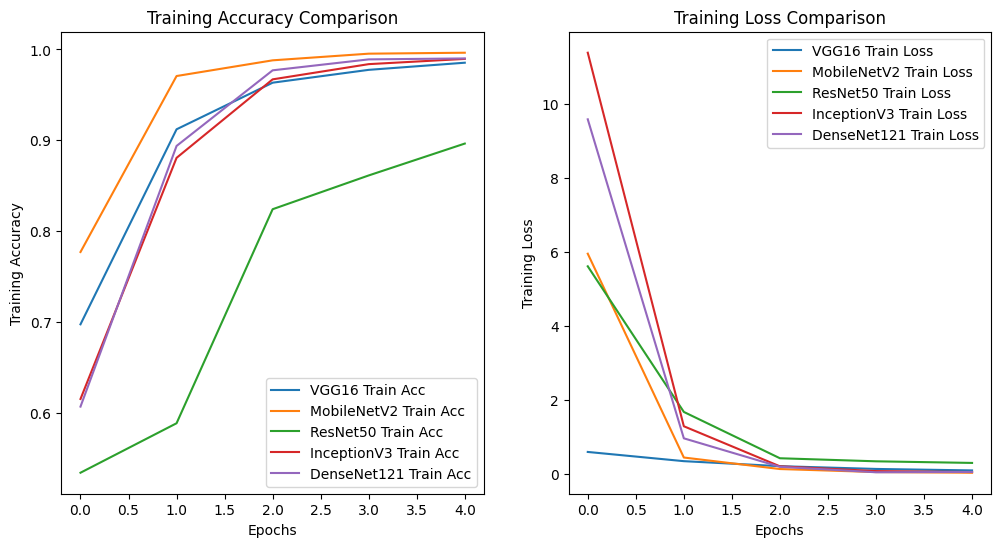

In [32]:
import matplotlib.pyplot as plt

def plot_training_curves(histories, model_names):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history["accuracy"], label=f"{name} Train Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend()
    plt.title("Training Accuracy Comparison")

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history["loss"], label=f"{name} Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.title("Training Loss Comparison")

    plt.show()

# Pass all histories
plot_training_curves(
    [history_vgg, history_mobile, history_resnet50, history_inception,history_DenseNet121],
    ["VGG16", "MobileNetV2", "ResNet50", "InceptionV3","DenseNet121"]
)


In [33]:
model_vgg.save("/kaggle/working/model_vgg16.h5")
model_mobilenet.save("/kaggle/working/model_mobilenetv2.h5")
model_resnet.save("/kaggle/working/model_resnet50.h5")
model_inception.save("/kaggle/working/model_inceptionv3.h5")
model_DenseNet121.save("/kaggle/working/model_DenseNet121.h5")

In [34]:
!zip -r models.zip /kaggle/working/*_model.h5


	zip warning: name not matched: /kaggle/working/*_model.h5

zip error: Nothing to do! (try: zip -r models.zip . -i /kaggle/working/*_model.h5)
